We will show how nonpositive definite neural achitecture can converge to bad solutions by looking at a simple LQR problem with infinite time-horizon

min $\int_0^\infty x^T Q x + u^T R u dt$

s.t. $\dot{x} = Ax + Bu$

In [5]:
import jax
import numpy as np
import jax.numpy as jnp
import optax
import scipy.linalg
import torch
import matplotlib.pyplot as plt
from flax import linen as nn
from torch.utils.data import Dataset, DataLoader
from utils.utils import np_collate

In [6]:
# Setup seed 
torch.random.manual_seed(0)
np.random.seed(0)
key = jax.random.PRNGKey(0)

We choose A,B,Q,R  all to be 2X2 identity matrices.
The cost-to-go, by solving a continounus-ARE equations using scipy is:

$V(x) = x^T \begin{bmatrix}2.41 &0\\0 &2.41\end{bmatrix} x$ 

In [7]:
A = np.array([[1,0],[0,1]])
B = np.array([[1,0],[0,1]])
Q = np.array([[1,0],[0,1]])
R = np.array([[1,0],[0,1]])
R_inv = scipy.linalg.inv(R)

P = scipy.linalg.solve_continuous_are(A,B,Q,R)
print(P)

[[2.41421356 0.        ]
 [0.         2.41421356]]


Define neural structures as MLPs. 

We would also make an PostiveValueApproximator to make the output positive

In [8]:
class ValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        y = nn.Dense(128)(x)
        y = nn.relu(y)
        y = nn.Dense(128)(y)
        y = nn.relu(y)
        y = nn.Dense(1)(y)

        return y.squeeze()
    
class PostiveValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        y = nn.Dense(128)(x)
        y = nn.relu(y)
        y = nn.Dense(128)(y)
        y = nn.relu(y)
        y = nn.Dense(1)(y)

        return jnp.exp(y).squeeze()

Generate datasets

In [9]:
xs = np.random.uniform(low=-1,high=1, size=(2**16, 2))

class StateDataset(Dataset):
    def __init__(self, xs):
        super().__init__()
        self.xs = xs
    def __len__(self):
        return self.xs.shape[0]
    def __getitem__(self, index):
        return self.xs[index]
    
dataset = StateDataset(xs)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=np_collate, drop_last=False)

Visualization tools

In [10]:
def visualize_learned_value_landscope(model, model_params, model_states, x_direction, y_direction, 
                        x_range=np.linspace(-1, 1, 51), y_range=np.linspace(-1, 1, 51), title="Learned value function"):
    """
    This function help to draw value function landscope for learn function,
    
    x_direction and y_direction should be perpenticular to each other, suppose a_i \in x_range, b_i \in y_range, then x_i = a_i * x_direction + b_i * y_direction.
    This is prepare for visualize state dimension higher than 2.

    Args:
        model: nn network object
        model_params: params for learned nn networks
        model_states: params for neural network states such as bn statistics
        x_direction: x axis direction
        y_direction: y axis direction
        x_range: the ranges for x direction
        y_range: the range for y direction
    """
    

    quick_apply = jax.jit(model.apply, static_argnames=["train"])
    X, Y = np.meshgrid(x_range, y_range)
    v_learned = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(Y.shape[1]):
            x = X[i,j] * x_direction
            x += Y[i,j] * y_direction
            v_learned[i,j] = quick_apply({"params":model_params, **model_states}, x)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, v_learned)
    ax.set_xlabel(f"direction: {np.round(x_direction, 2)}")
    ax.set_ylabel(f"direction: {np.round(y_direction, 2)}")
    ax.set_zlabel('value')
    plt.title(title)

def visualize_lqr_value_landscope(P, x_direction, y_direction, x_range=np.linspace(-1, 1, 51), y_range=np.linspace(-1, 1, 51), title="LQR value function"):
    """
    This function help draw lqr value function,

    Args:
        P: the value function P matrix for lqr
        x_direction: x axis direction
        y_direction: y axis direction
        x_range: the ranges for x direction
        y_range: the range for y direction
        title: tilte for the visualization
    """

    X, Y = np.meshgrid(x_range, y_range)
    v_lqr = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(Y.shape[1]):
            x = X[i,j] * x_direction
            x += Y[i,j] * y_direction
            v_lqr[i,j] = x.T @ P @ x

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, v_lqr)
    ax.set_xlabel(f"direction: {np.round(x_direction, 2)}")
    ax.set_ylabel(f"direction: {np.round(y_direction, 2)}")
    ax.set_zlabel('value')
    plt.title(title)

Visualize coefficient of P that satisfy 

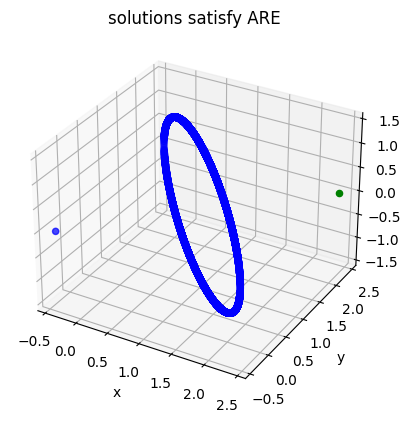

In [24]:
num = 10000
x = np.random.uniform(low=1 - 2**0.5, high=1 + 2**0.5, size=num)
y = 2 - x
z = np.random.choice([-1,1],size=num) * (2 * x + 1 - x**2) **0.5

x = list(x)
y = list(y)
z = list(z)

x.extend([1-2**0.5, 1-2**0.5, 1+2**0.5])
y.extend([1-2**0.5, 1+2**0.5, 1-2**0.5])
z.extend([0, 0, 0])

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(x, y, z, color="blue", label="solution satisfy ARE")
ax.scatter3D([1+2**0.5],[1+2**0.5],[0], color="green", label="positive definite solution" )
plt.title("")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("solutions satisfy ARE")
ax.legend()
plt.show()

Visualize LQR value function

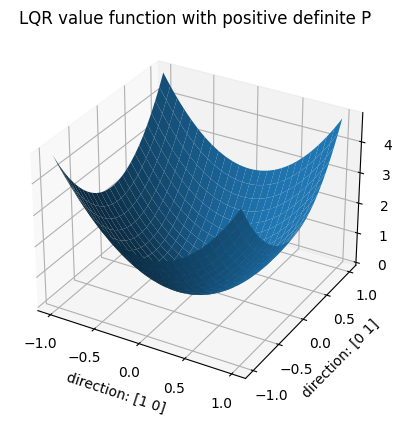

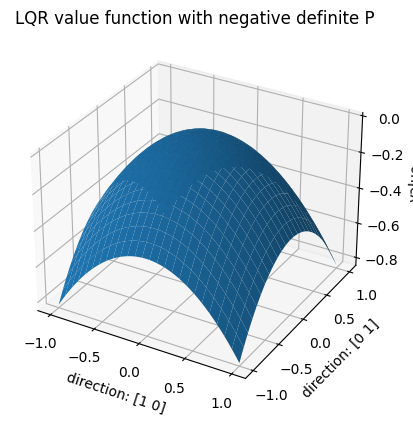

In [11]:
x_direction = np.array([1,0])
y_direction = np.array([0,1])
visualize_lqr_value_landscope(P, x_direction=x_direction, y_direction=y_direction, title="LQR value function with positive definite P")
visualize_lqr_value_landscope(np.eye(2) * (1-2**0.5), x_direction=x_direction, y_direction=y_direction, title="LQR value function with negative definite P")


Training for simple MLP structures

epoch:10 loss:0.47776705026626587
epoch:20 loss:0.47897741198539734


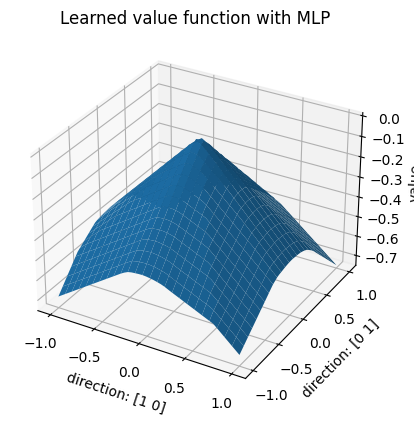

In [12]:
value_function_approximator = ValueApproximator()
key, key_to_use = jax.random.split(key)
model_variables = value_function_approximator.init(key_to_use, jnp.zeros((1,2)))
model_states, model_params = model_variables.pop('params')
del model_variables
optimizer = optax.adam(learning_rate=1e-3)
optimizer_states = optimizer.init(model_params)

def hjb_loss(params, states, xs):
    def get_v_gradient(params, states, x):
        return jax.grad(value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))
    def loss(x):
        v_gradient, updated_states = get_v_gradient(params, states, x)
        u = R_inv @ B.T @ v_gradient / 2
        x_dot = A @ x + B @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot + x.T @ Q @ x + u.T @ R @ u)
        return loss, updated_states    
    batch_losses, updated_states = jax.vmap(loss)(xs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def params_update(params, states, optimizer_state, xs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(hjb_loss, has_aux=True)(params, states, xs)
    updates, optimizer_state = optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

losses = []
for epoch in range(20):
    total_loss = 0
    for i, xs in enumerate(dataloader):
        model_params, model_states, optimizer_states, loss = params_update(model_params, model_states, optimizer_states, xs)
        total_loss += loss
    losses.append(total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{total_loss / len(dataloader)}")

visualize_learned_value_landscope(value_function_approximator, model_params, model_states, x_direction=x_direction, y_direction=y_direction, title="Learned value function with MLP")


Training for architecture guarantees postive value function

epoch:10 loss:0.44809794425964355
epoch:20 loss:0.4468139708042145


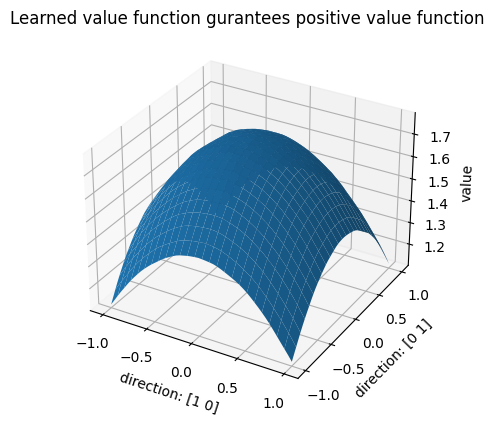

In [13]:
value_function_approximator = PostiveValueApproximator()
key, key_to_use = jax.random.split(key)
model_variables = value_function_approximator.init(key_to_use, jnp.zeros((1,2)))
model_states, model_params = model_variables.pop('params')
del model_variables
optimizer = optax.adam(learning_rate=1e-3)
optimizer_states = optimizer.init(model_params)

def hjb_loss(params, states, xs):
    def get_v_gradient(params, states, x):
        return jax.grad(value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))
    def loss(x):
        v_gradient, updated_states = get_v_gradient(params, states, x)
        u = R_inv @ B.T @ v_gradient / 2
        x_dot = A @ x + B @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot + x.T @ Q @ x + u.T @ R @ u)
        return loss, updated_states    
    batch_losses, updated_states = jax.vmap(loss)(xs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def params_update(params, states, optimizer_state, xs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(hjb_loss, has_aux=True)(params, states, xs)
    updates, optimizer_state = optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

losses = []
for epoch in range(20):
    total_loss = 0
    for i, xs in enumerate(dataloader):
        model_params, model_states, optimizer_states, loss = params_update(model_params, model_states, optimizer_states, xs)
        total_loss += loss
    losses.append(total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{total_loss / len(dataloader)}")

visualize_learned_value_landscope(value_function_approximator, model_params, model_states, x_direction=x_direction, y_direction=y_direction, title="Learned value function gurantees positive value function")
